# Classification - Nearest Neighbors

# *Data set Information*
> Features Description:
* Pregnancies → Number of times pregnant
* Glucose → Plasma glucose concentration 2 hours in an oral glucose tolerance
test
* BloodPressure → Diastolic blood pressure (mm Hg)
* SkinThickness → Triceps skin fold thickness (mm)
* Insulin → 2-Hour serum insulin (mu U/ml)
* BMI → Body mass index (weight in kg/(height in m)^2)
* DiabetesPedigreeFunction → Diabetes pedigree function
* Age → Age (years)

> Target	Variable:
* Outcome - Class variable (0 or 1) (diabeties absent or present)


# *Required python packages*

In [1]:
pip install fancyimpute

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.3 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29879 sha256=4b8b56f381b612e480f807c0ad781228d22372f05845653064b49a7fcabfed7c
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11329 sha256=7a47c6cf9e61cc497d4400688910d1641c4a746bb49f11e200e064006bad0988
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092408b3a7bf754
Successfully built fancyimpute knnimpute


In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from fancyimpute import KNN
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score

#Retriving data
The Python code below reads the dataset into a Pandas data frame with the name 'df'. For this code to work, the file dataset_KNN.csv must be in the same folder as this file.

In [3]:
data = pd.read_csv('dataset_KNN.csv')
df=pd.DataFrame(data)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


# Exploratory Data Analysis

In [4]:
print("Shape of diabetes data: ", df.shape)

Shape of diabetes data:  (768, 9)


Data set consist of 768 rows of data, with 9 features.

In [5]:
#some basic understanding of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


all the attribute types are numerical, hence we don't need to do any Feature engineering

In [6]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

the outcome colum consist of 500 non diabetic patient and 268 diabetic patients

In [7]:
# count the number of duplicated rows in the dataset
print('number of duplicated rows in the dataset: ', df.duplicated().sum())

number of duplicated rows in the dataset:  0


In [8]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

#Pearson's Correlation Coefficient before data preprocessing

* The linear correlation between two variables is quantified by Pearson's correlation coefficient. Its value falls between -1 and 1.
* -1 denoting a cooler hues, such as blue, denote a negative correlation.
0 denoting no connection. and, 1 denoting Warmer hues, such as red, denote a perfect positive correlation.

*   the Features that are highly correlated to the target variable should not be dropped
*   the features that are highly inter related(correlated features)(duplicate features) we should Voluntarily use just 1 feature.



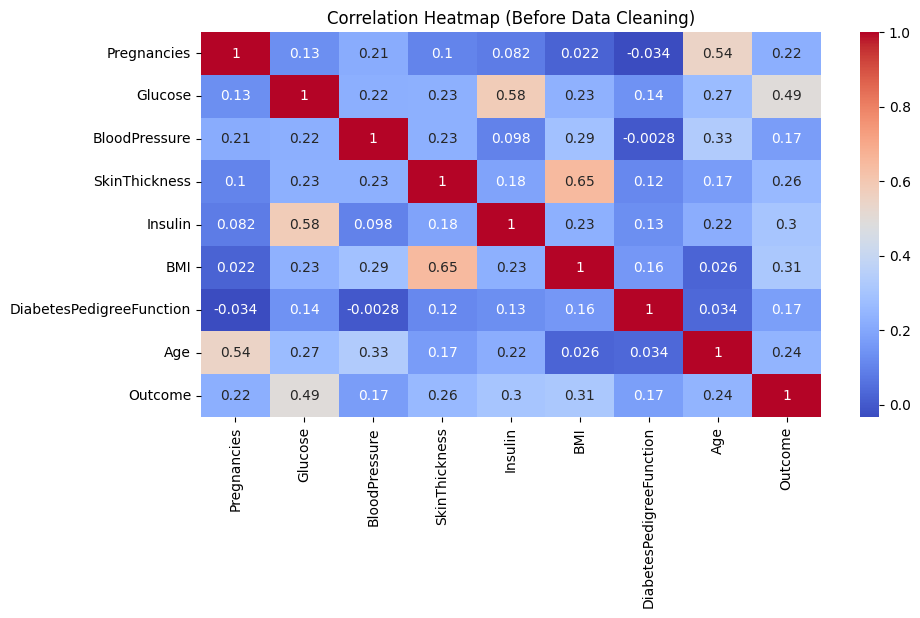

In [9]:
# Check the correlation between variables using Pearson's Correlation Coefficient
plt.figure(figsize=(10,5))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Before Data Cleaning)')
plt.show()

we can Observe:
* BMI and SkinThickness features are highest correlated with each other (0.65) followed by Insulin and Glucose (0.58)
* Glucose is the highest correlated to the target variable(Outcome)



# Data Pre-processing (Handeling Missing Values)

In [10]:
#check for missing values
print(df.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


as we can see there are missing values in the features such as Glucose,    BloodPressure and BMI where as SkinThickness and Insulin has a significant number of missing values                        

for missing values in Glucose, BloodPressure and BMI we will use simpler imputation approaches like median, to fill in the missing data.

In [11]:
# Define columns with missing values
columns_with_missing_values = ['Glucose', 'BloodPressure', 'BMI']

# Apply SimpleImputer to fill missing values with the median of each column
imputer = SimpleImputer(strategy='median')
df[columns_with_missing_values] = imputer.fit_transform(df[columns_with_missing_values])


when dealing with features that have a significant number of missing values, you can use more advanced imputation techniques. One commonly used method is K-Nearest Neighbors (KNN) imputation. KNN imputation estimates missing values by finding the nearest neighbors for each missing value based on the available data

In [12]:
# Assuming df is your DataFrame
columns_with_missing_values = ['SkinThickness', 'Insulin']

# Perform KNN imputation for the selected columns
imputed_df = KNN(k=5).fit_transform(df[columns_with_missing_values])

# Convert the imputed values back to a DataFrame
imputed_df = pd.DataFrame(imputed_df, columns=columns_with_missing_values)

# Update the original DataFrame with the imputed values
df[columns_with_missing_values] = imputed_df

# Set the default value for any remaining missing values in the imputed columns to the median
for col in columns_with_missing_values:
    median = np.median(df[col])
    df[col] = df[col].apply(lambda x: median if x == 0 else x)  # Replace zero with the median

# Now, any missing values that couldn't be imputed have been set to the median of their respective column


Imputing row 1/768 with 1 missing, elapsed time: 0.081
Imputing row 101/768 with 2 missing, elapsed time: 0.082
Imputing row 201/768 with 1 missing, elapsed time: 0.085
Imputing row 301/768 with 2 missing, elapsed time: 0.086
Imputing row 401/768 with 2 missing, elapsed time: 0.088
Imputing row 501/768 with 0 missing, elapsed time: 0.089
Imputing row 601/768 with 1 missing, elapsed time: 0.091
Imputing row 701/768 with 0 missing, elapsed time: 0.092
[KNN] Warning: 454/1536 still missing after imputation, replacing with 0


Note: the ouput says that it is replacing with 0 but it is actually being replaced with median as you can see below that the feature doen't contain any rows with the value 0

In [13]:
df[df['Insulin']==0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [14]:
df[df['SkinThickness']==0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [15]:
# check if the missing values exist
print(df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


# Rechecking Pearson's Correlation Coefficient relation between varaibles using Heat Map after data cleaning (After preprocessing)

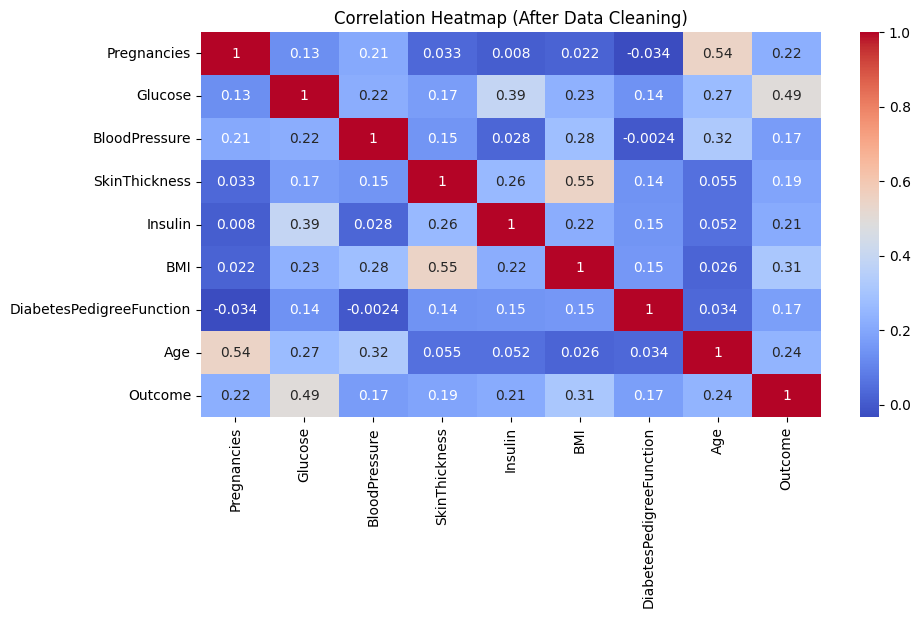

In [16]:
# Check the correlation between variables after data cleaning
plt.figure(figsize=(10,5))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (After Data Cleaning)')
plt.show()


* BMI and SkinThickness features are still the highest correlated with each other (0.55) but now are followed by Age and Pregnancies (0.54)
* Glucose is still the highest correlated out of all to the target variable(Outcome)

In [17]:
# extract the indices of the top 3 features that have the highest correlation with the target variable(outcome), in descending order of correlation strength.
top_features = abs(correlation_matrix["Outcome"]).sort_values(ascending=False)
print("features based on correlation with target variable:"'\n',top_features[1:]) # we take from 2nd value as outcome is highly correlated to itself

features based on correlation with target variable:
 Glucose                     0.492782
BMI                         0.312038
Age                         0.238356
Pregnancies                 0.221898
Insulin                     0.209261
SkinThickness               0.189065
DiabetesPedigreeFunction    0.173844
BloodPressure               0.165723
Name: Outcome, dtype: float64


We can see that the highly correlated features are still present, but now there are no missing values. In addition, we can see that Glucose, BMI and Age have the highest absolute correlation coefficients with the target variable (Outcome).

#Feature Selection

In [18]:
# Splitting the dataset into features and target variable
# contains all the columns except the last column, which is the target variable
features = df.iloc[:, :-1]
#Contains only the target variable 'Outcome'
target = df.iloc[:, -1]

In [19]:
# Selecting the best k features using f_regression score function
k_best = SelectKBest(score_func=f_regression, k=3).fit(features, target)

# Creating a dataframe to store feature scores
df_scores = pd.DataFrame(k_best.scores_, columns=['Score'], index=features.columns)

# Sorting the features based on their scores in descending order
df_scores = df_scores.sort_values('Score', ascending=False)

# Printing the features with the score
print(df_scores[:3])


              Score
Glucose  245.667855
BMI       82.629271
Age       46.140611


*My selection criteria for the three attributes were based on their association with the goal variable (Outcome) as well as their capacity to offer insightful data for diabetes prediction. I specifically picked glucose, BMI, and Age since they had the high absolute correlation coefficients with the target variable and using the f_regression score function having highest score with the target variable and are frequently acknowledged as significant risk factors for diabetes.*

Here is the code to visualize the target variable with respect to the three most significant attributes in a 2D projection:

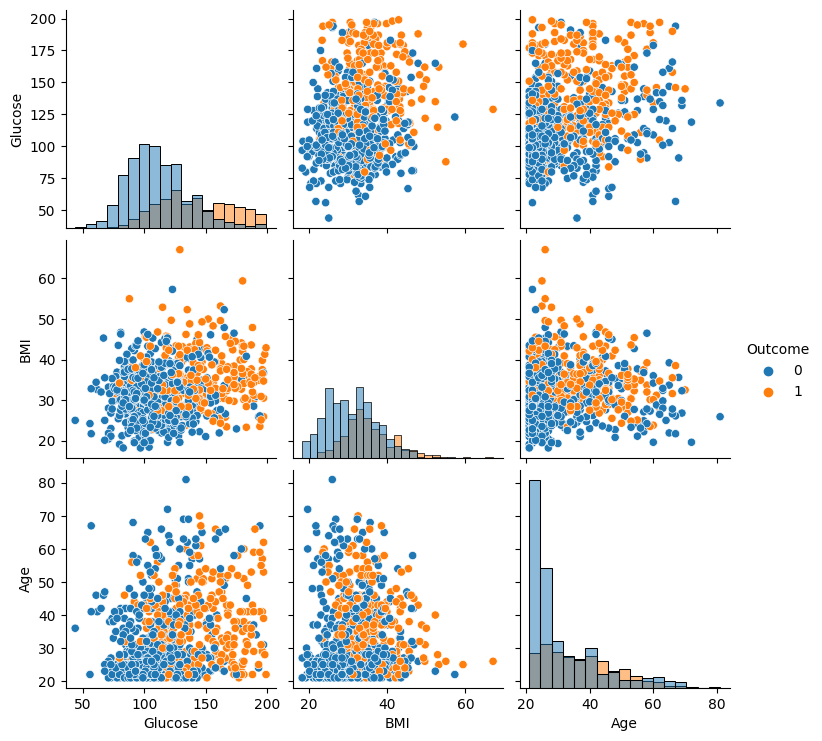

In [20]:
sns.pairplot(data=df, vars=['Glucose', 'BMI', 'Age'], hue='Outcome', diag_kind='hist')

we have created a scatter plots for each pair of attributes.
* a scatter plot of 'Glucose' versus 'Outcome' shows that higher levels of
glucose are generally associated with a higher risk of diabetes.
* a scatter plot of 'BMI' versus 'Outcome' shows that higher BMI values are also associated with a higher risk of diabetes.
* Glucose have a almost Normal distribution
* BMI has a right skewed distribution, That means concentration of individuals have lower BMI value (where many people have avg or below avg values and few people have higher values)
* Age has a Log Normal distribution

* What other 3 attribute can
you choose?*

Pregnancies,Insulin, and SkinThickness are the remaining three options. Given that women with a history of gestational diabetes or a large number of pregnancies are more likely to acquire diabetes, pregnancy may be a reliable indicator of diabetes risk. Insulin level and diabetes frequently coexist, which is another widely acknowledged risk factor for diabetes. Diabetes mellitus patients frequently have thick skin on the hands and fingers, and the condition increases the risk of diabetic retinal microvascular disease..

In [21]:
#features you need to drop
df_scores[3:]

,Score
Pregnancies,39.670227
Insulin,35.079280
SkinThickness,28.396277
DiabetesPedigreeFunction,23.871300
BloodPressure,21.631580


In [22]:
drop_column = ['SkinThickness', 'Insulin', 'Pregnancies', 'BloodPressure', 'DiabetesPedigreeFunction']
features = features.drop(drop_column, axis=1)

#Scaling the data using Standard Scaling

With the Nearest Neighbors method, a new instance's class can be predicted based on the classes of its k closest neighbors in the training set. Because the KNN technique is distance-based and the distance between instances can be significantly influenced by the magnitude of the features, scaling is crucial  for KNN because it is a distance-based algorithm. If the features are not scaled, the distance metric will be dominated by characteristics with big values, making features with lesser values less significant. By scaling the data, we ensure that all features are on the same scale and have equal importance.

In [23]:
features.head(3)

,Glucose,BMI,Age
0,148.0,33.6,50
1,85.0,26.6,31
2,183.0,23.3,32


we now proceed to scale the data using the StandardScaler technique. This will scale the data to have a mean of 0 and standard deviation of 1.

In [24]:
# Scale the data using StandardScaler
scaler = StandardScaler()
# The fit_transform method of the StandardScaler is used to fit the scaler to the data in features and then transform it into the scaled data.
features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
features.head(3)

,Glucose,BMI,Age
0,0.866045,0.166619,1.425995
1,-1.205066,-0.852200,-0.190672
2,2.016662,-1.332500,-0.105584


# Split dataset 80% for training, and 20% for testing and do cross validation for the classifier

Let's now examine how we can use scikit-learn to apply the k-nearest neighbors algorithm. Furthermore, in order to assess generalization performance, we divided our data into a training and a test set:

In [25]:
# features, target
# Split the dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=2, stratify=target)

note that this function divides the dataset into training and test sets at random. A pseudo-random number generator, which produces random numbers using a seed, regulates the randomness. you will actually always receive the same partition if you fix the seed.

Next, we instantiate the KNeighborsClassifier class.
*Use Euclidean distance*

In [26]:
# Creating KNN classifier object
knn = KNeighborsClassifier(metric='euclidean')

We can then perform cross-validation for our KNN classifier with 10 folds using the cross_val_score function from scikit-learn.

In [27]:
# Cross-validation for the classifier
cv_scores = cross_val_score(knn, X_train, y_train, cv=10)

In [28]:
# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))

Cross-Validation Scores: [0.74193548 0.72580645 0.75806452 0.69354839 0.78688525 0.72131148
 0.78688525 0.80327869 0.6557377  0.75409836]
Mean CV Score: 0.7427551560021153


# Finding the best K using elbow method.

In KNN, the elbow method can be used to find the optimal value of K, which is the number of nearest neighbors used to make predictions.By finding the optimal value of K using the elbow method, we can ensure that our KNN model is both accurate and efficient. We can plot the within-cluster sum of squares (WCSS) against the number of clusters (K), and select the K value at the elbow point where the rate of decrease in WCSS slows down and forms an elbow-shaped pattern.

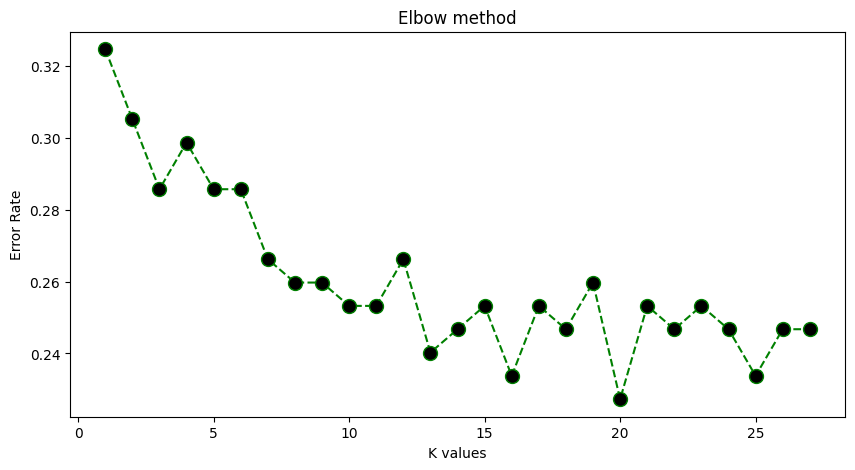

In [29]:
plt.figure(figsize=(10,5))
# create empty lists for the errors rate of different K values
error_rate = []
# loop through different K values it creates a KNN classifier object with the specified value of k and the Euclidean distance metric.
for k in range(1, 28):
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train, y_train) #The classifier is then fitted on the training data
    y_pred = knn.predict(X_test) # method of the classifier used to make predictions on the test data
    array=np.mean(y_pred != y_test) #The error rate is calculated as the mean of the Boolean array which checks whether the predicted values are not equal to the actual value
    error_rate.append(array) #will append to the list
# plot the elbow curve
plt.plot(range(1, 28), error_rate, color='green', linestyle='dashed', marker='o', markerfacecolor='black', markersize=10)
plt.title('Elbow method')
plt.xlabel('K values')
plt.ylabel('Error Rate')
plt.show()

This code loops through K values ranging from 1 to 28 and calculates the mean error using elbow method. It then plots the elbow curve to visualize the mean error for each K value.
Until 13 you can notice a huge reduction in variation, but after that, the variation doesn't go down as quickly.Therefore, we will select K=13 as our best K value

#Plot the ROC curve for best K value

Finally, we will plot the ROC curve for our best K value, which is K=13. Here's the code

In [30]:
# Fit the classifier with the best K value
# Fit KNN model to training data
knn = KNeighborsClassifier(n_neighbors=13, metric='euclidean')
knn.fit(X_train, y_train)

# Predict on testing data and print evaluation metrics
y_pred = knn.predict(X_test)
# Print the confusion matrix, classification report, and ROC curve
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification report:")
print(classification_report(y_test, y_pred))

Confusion matrix:
[[88 12]
 [25 29]]
Classification report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       100
           1       0.71      0.54      0.61        54

    accuracy                           0.76       154
   macro avg       0.74      0.71      0.72       154
weighted avg       0.75      0.76      0.75       154



The confusion matrix shows that for k=13, we correctly predicted 88 non-diabetic patients and 29 diabetic patients, while incorrectly predicting 12 non-diabetic patients as diabetic and 25 diabetic patients as non-diabetic. The classification report shows that the recall, and f1-score of both classes have a significant difference

The ROC curve plots the true positive rate (sensitivity) against the false positive rate (1-specificity) for different classification thresholds.ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes.

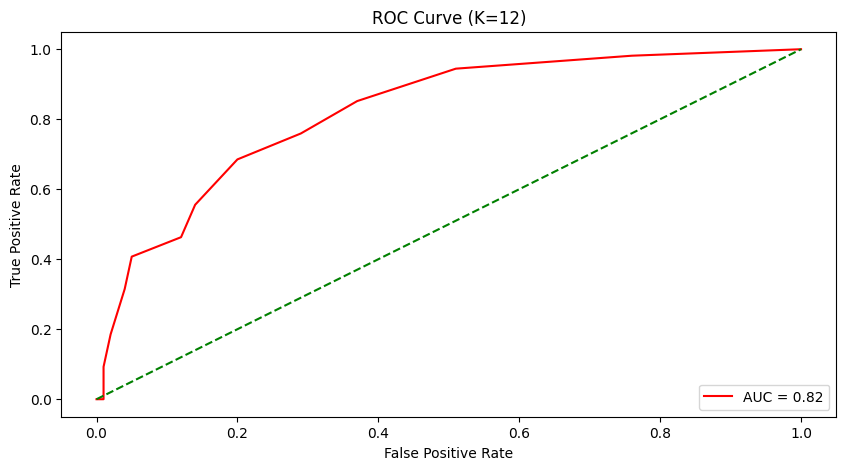

In [31]:
plt.figure(figsize=(10,5))
# fit the classifier using K=12 and predict the probabilities
knn = KNeighborsClassifier(n_neighbors=12, metric='euclidean')
knn.fit(X_train, y_train)
y_prob = knn.predict_proba(X_test)[:, 1]

# calculate the false positive rate, true positive rate, and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

# plot the ROC curve
plt.plot(fpr, tpr, 'r-', label='AUC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], 'g--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (K=12)')
plt.legend(loc='lower right')
plt.show()

there is a 82% chance that the model will be able to distinguish between positive class and negative class.

# Testing the classifier with three different k values


Next, we will test the classifier with three different K values and record the results. We will use K=7, K=16, and K=20 for this purpose. Here's the code:

In [36]:
# create a list of K values
K= [7,16,20]
# loop through different K values and fit the classifier, and prints the accuracy score for each K value.
for k in K:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy for K =", k, "is", acc)


Accuracy for K = 7 is 0.7337662337662337
Accuracy for K = 16 is 0.7662337662337663
Accuracy for K = 20 is 0.7727272727272727


#Calculate and print the confusion matrix, and the classification Report (includes:precision, recall, f1-score, and support) for all three different numbers.

here is the code for the confusion matrix, classification report for 3 different k values

In [37]:
# Fit the classifier with three different k values and record the results
for k in [7, 16, 20]:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print(f"\nK value: {k}")
    print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
    print('Classification Report:\n', classification_report(y_test, y_pred))


K value: 7
Confusion Matrix:
 [[86 14]
 [27 27]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.86      0.81       100
           1       0.66      0.50      0.57        54

    accuracy                           0.73       154
   macro avg       0.71      0.68      0.69       154
weighted avg       0.73      0.73      0.72       154


K value: 16
Confusion Matrix:
 [[91  9]
 [27 27]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.83       100
           1       0.75      0.50      0.60        54

    accuracy                           0.77       154
   macro avg       0.76      0.71      0.72       154
weighted avg       0.76      0.77      0.75       154


K value: 20
Confusion Matrix:
 [[91  9]
 [26 28]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.91      0.84       100
           1 


### Interpretation:
- As K increases from 7 to 16 and then to 20, the precision for class 1 increases, indicating a better ability to correctly identify positive instances.
- However, the recall for class 1 remains relatively stable and slightly increases as K increases. This suggests that the model is able to capture more  some positive instances as K increases.
- The F1-score balances precision and recall, and it also shows improvement for class 1 as K increases.
- The overall accuracy improves from 73% (K=7) to 77% (K=16 and K=20).



# Plot the Error rate vs. K-value

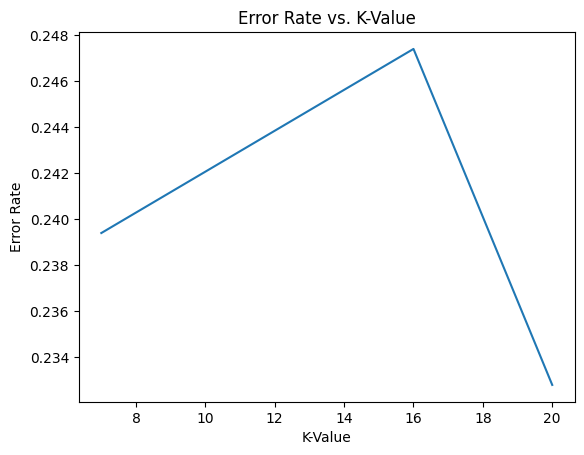

In [38]:
# Error rate vs K-value plot
error_rates = []
l=[7, 16, 20]
for k in l:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    scores = cross_val_score(knn, X_train, y_train, cv=10)
    error_rates.append(1 - scores.mean())

plt.plot(l, error_rates)
plt.title('Error Rate vs. K-Value')
plt.xlabel('K-Value')
plt.ylabel('Error Rate')
plt.show()


* Based on the error rate plot, it appears that the error rate decreases as K increases.
* The error rate vs K-value plot shows that the lowest error rate is achieved at k=20 and the lowest error rate (0.232)

In conclusion, K-Nearest Neighbors (KNN) proved effective for classification in this project, demonstrating its simplicity and versatility. Scaling ensured uniform attribute impact in distance calculations. Glucose, Insulin, and BMI were selected based on high correlation and iterative imputation scores. The results highlighted the nuanced relationship between K values, precision, and recall. Optimal K choice impacts the classifier's accuracy, emphasizing the need for a balanced approach. Addressing missing values and handling feature correlations were essential steps in enhancing the KNN classifier's performance.